In [24]:
# compare most frequent words
# compare sentiment in most frequent common post size? in short posts?

# say more on rank analysis of individual words
# say more on analysis of pairs of words

# obtain true counts of emphasized words
# in both subreddits for comparison

# Distinguishing r/Seattle and r/SeattleWA

## Problem Statement

#### Background
*Reddit* is a forum like website that is partitioned into many communities called *subreddits*. These subreddits, often prefixed with 'r/', provide a space for people all over the world to interact with one another and share things related to the specific subreddit. Some examples of subreddits or r/explainlikeimfive, r/cooking, and r/SanFrancisco.
 
Since anyone can create a subreddit, many subreddits exist that appear to serve the same purpose on the surface. Usually these subreddits will still have their own differences that distinguish them from one another and justify their existence.

For example, there are several subreddits related to the city of Seattle: r/Seattle and r/SeattleWA. Someone who has not explored these subreddits very thoroughly may have a question to ask about Seattle and not know which subreddit would be the most fitting to post in.

#### Problem Statement
In this project we:
- explore the text data from posts on r/Seattle and r/SeattleWA
- try to identify notable ways in how these two subreddits differ
- and build classification models to try and predict if a post is more likely to come from r/Seattle or r/SeattleWA

Since r/Seattle and r/SeattleWA are likely to have very similar users and posts (there are certainly people who participate in both subreddits), it will be challenging to build a model that can perform strong predictions. We will deem our model successful if it can correctly classify which subreddit a post belongs to more than 60% of the time.

---

## Imports and Functions

In [25]:
# for pulling data and slowing request rate
import requests
import time

# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# text imports
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# visualization import
import plotly.express as px

In [57]:
ps = PorterStemmer()
ps.stem('positive')

'posit'

In [26]:
def scrape_subreddit(subreddit):
    '''
    Given subreddit's name, request the most recent 2,250
    posts from the given subreddit.
    
    Combines the data into a csv file.
    '''
    
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {'subreddit': subreddit,
              'size': 250,
              'is_self': True,
              'selftext:not': '[removed]'}
    
    # assigns post data to variable 'posts'
    data = requests.get(url, params).json()
    posts = data['data']
    
    # adds the earliest post time to the 'before' API parameter
    # next request will collect posts before this time
    params['before'] = posts[-1]['created_utc']
    
    time.sleep(30)
    
    while len(posts) < 2_250:
        # collects next batch of posts data as 'next_posts'
        next_data = requests.get(url, params).json()
        next_posts = next_data['data']
        
        # concatenate posts data to 'posts'
        posts += next_posts
        
        # update API parameters to so the following 250 posts
        # will be requested in the next iteration of the loop
        earliest_post_time = next_posts[-1]['created_utc']
        params['before'] = earliest_post_time
        
        # delay next request and not spam the API
        time.sleep(30)
        
    posts_df = pd.DataFrame(posts)
    posts_df.to_csv(f'datasets/{subreddit}.csv', index = False)
    

def text_cleaning(text):
    '''
    Cleans text by removing [bracketed statements], urls, emails,
    some special characters (parentheses and stars), and some common html phrases.
    
    Returns the cleaned text
    '''
    
    # remove new lines
    text = re.sub('\n', ' ', text)
    
    # remove parentheses and asterisks
    text = re.sub("[\(\)\*]", '', text)
    
    # remove urls and do not include closing bracket ]
    text = re.sub('http\S+|www\.\S+', '', text)
    
    # remove email accounts
    text = re.sub('\S+@\S+', '', text)
    
    # remove bracketed strings
    text = re.sub('\[(\w|\s)*\]', '', text)
    
    # remove any leftover brackets
    text = re.sub('[\[\]]', '', text)
    
    # replace parentheses with spaces
    text = re.sub("/", ' ', text)
    
    # remove some common html phrases
    text = re.sub('&(gt|lt);', '', text)
    text = re.sub('&?amp;', '', text)
    text = re.sub('&?#x200b;?', '', text)
    text = re.sub('&?#x200B;?', '', text) 
    
    # replace whitespace with single space
    text = re.sub('\s+', ' ', text)
    
    # punctuation will be dropped after collecting sentiment
    # , ; : . ! ?
        
    return text


# although stop_drop_and_stem is a cooler name
# it would be slightly less clear :(
def drop_stop_and_stem(text):
    '''
    Takes a string, drops the stop words,
    and stems the remaining words with PorterStemmer.
    
    Returns the stemmed, non-stopwords
    '''
    
    pstem = PorterStemmer()
    
    #stem non-stopwords and put into a list
    stemmed_list = [pstem.stem(word) for word in text.split()
                    if word not in stopwords.words('english')]
    
    # return words separated by a space
    return ' '.join(stemmed_list)


def create_sentiment(df):
    '''
    Using Vader, collects sentiment from a DataFrame's "text" column.
    Creates three new columns titled "sent_pos", "sent_neg", and "sent_comp" from the 
    positive, negative, and compound sentiment scores.
    
    Returns the DataFrame with additional columns "sent_pos", "sent_neg", and "sent_comp".
    '''
    
    sent = SentimentIntensityAnalyzer()
    
    df['sent_pos'] = df['text'].apply(lambda x: sent.polarity_scores(x)['pos'])
    df['sent_neg'] = df['text'].apply(lambda x: sent.polarity_scores(x)['neg'])
    df['sent_compound'] = df['text'].apply(lambda x: sent.polarity_scores(x)['compound'])
    

def sample_three(series):
    '''
    Prints three random entries from a given series.
    '''
    for entry in series.sample(3):
        print(entry)
        print('----------\n')

---

## Collecting the Data

The code cell below uses the function `scrape_subreddit` to collect data on more than 2,000 posts from each subreddit r/Seattle and r/SeattleWA using [pushshift API](https://github.com/pushshift/api). The cell is commented out so that the results are consistent based on originally scraped datasets.

In [27]:
# collect more than 2,250 posts from /r/Seattle and /r/SeattleWA subreddits
# commented out because the data has already been collected

#scrape_subreddit('Seattle')
#scrape_subreddit('SeattleWA')

---

## Cleaning
#### First Impressions

Let us read in the data and get a sense of what the data looks like.

In [28]:
sea = pd.read_csv('datasets/Seattle.csv')
sea_wa = pd.read_csv('datasets/SeattleWA.csv')

In [29]:
sea.head(5)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,thumbnail_width,post_hint,preview,collections,author_flair_template_id,author_cakeday,distinguished,call_to_action,category,removed_by_category
0,[],False,Remarkable-Salt610,NaN,[],NaN,text,t2_ni0lq3vz,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,westrox11,NaN,[],NaN,text,t2_12a2u1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Soggy_Sneakers87,NaN,[],NaN,text,t2_a0vuvfra,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,LittleShallot,NaN,[],NaN,text,t2_13biud,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Chuckforpresident,NaN,[],NaN,text,t2_3xq1mh9j,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
sea.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_text_color', 'link_flair_type',
       'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts',
       'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'total_awards_rece

Most of the data is filled with missing and most of the columns seem irrelevant to our goals. The `subreddit`, `title`, and `selftext` columns are our main interest since we want to distinguish the two subreddits based on the text content of each post.

Beyond this, `author` and `created_utc` may be relevant so let us keep these columns too.

In [31]:
# columns of interest
init_cols = ['subreddit', 'author', 'created_utc', 'title', 'selftext']

sea = sea[init_cols].copy()
sea_wa = sea_wa[init_cols].copy()

Let us see if there are any blatant things to clean in the data.

In [32]:
sea.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       0
dtype: int64

In [33]:
sea_wa.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       3
dtype: int64

In [34]:
print(sea.shape)
print(sea_wa.shape)

(2499, 5)
(2499, 5)


There should not be any harm in removing three entries with missing selftext data out of nearly 2,500 posts.

In [35]:
sea_wa.dropna(inplace = True)

#### Feature Engineering: Combined Text, Sentiment, and Word Count

One thing we will want to collect is the sentiment and word count of each post in case there are any general differences here between the two subreddits.

Before we do this, we can make our lives a little easier by concatenating the `title` and `selftext` data into a single column.

In [36]:
# create a new column from joining title text and selftext
sea['text'] = sea['title'] + ' ' + sea['selftext']
sea_wa['text'] = sea_wa['title'] + ' ' + sea_wa['selftext']

# drop former text columns
sea.drop(columns = ['title', 'selftext'], inplace = True)
sea_wa.drop(columns = ['title', 'selftext'], inplace = True)

We will also need to clean our text data before we collect the sentiment and word counts. This will hopefully make the resulting values more meaningful. Below we use our `text_cleaning` function to do basic cleaning like remove urls, select special characters, and bracketed text.

In [37]:
# remove urls and emails, special characters ()/*, and [bracketed strings]
sea['text'] = sea['text'].apply(text_cleaning)
sea_wa['text'] = sea_wa['text'].apply(text_cleaning)

Finally we use `vader` from `nltk` to collect the sentiment. Afterwards we drop the stopwords and stem. We collect sentiment first because `vader` may have trouble performing sentiment analysis on stemmed text.

In [38]:
# in place methods that generate positive and negative sentiment scores
# for the given dataframes
create_sentiment(sea)
create_sentiment(sea_wa)

In [39]:
# drop some leftover punctuation - some of which was necessary for sentiment analysis
sea['text'] = sea['text'].apply(lambda text: re.sub('[,;\.!\?]', '', text))
sea_wa['text'] = sea_wa['text'].apply(lambda text: re.sub('[,;\.!\?]', '', text))

In [40]:
# count number of words by splitting text across white space and recording list length
sea['word_count'] = sea['text'].str.split().str.len()
sea_wa['word_count'] = sea_wa['text'].str.split().str.len()

As a sanity check, let us see if the head of our DataFrames match our general expectations.

In [41]:
sea.head(3)

,subreddit,author,created_utc,text,sent_pos,sent_neg,sent_compound,word_count
0,Seattle,Remarkable-Salt610,1664407377,Special Education in Seattle or surrounding ar...,0.111,0.000,0.8406,94
1,Seattle,westrox11,1664403922,Best Lychee martini in Seattle I’m on the hunt...,0.374,0.000,0.9178,23
2,Seattle,Soggy_Sneakers87,1664402515,Save a life Hi I just learned in a CPR first a...,0.211,0.014,0.9756,118


In [42]:
sea_wa.head(3)

,subreddit,author,created_utc,text,sent_pos,sent_neg,sent_compound,word_count
0,SeattleWA,Sinkholediaries,1664416603,Archspire fans I'm a lady who is obsessed I ne...,0.206,0.284,-0.4939,31
1,SeattleWA,prf_q,1664406559,Is it the overseeding season yet Those who are...,0.069,0.000,0.3485,35
2,SeattleWA,eatmoremeatnow,1664404071,Showbox Box Office Has anybody recently bought...,0.034,0.058,-0.3270,55


#### Cleaning

We performed a lot of text cleaning, but there may be some posts that need to be removed on the whole due to having duplicate posts or being outliers.

Below we see the number of duplicate posts in each subreddit and what they look like in r/SeattleWA.

In [23]:
print(f"Number of duplicates posts in r/Seattle: {sea[sea['text'].duplicated()].sort_values(by = 'author').shape[0]}")
print(f"Number of duplicates posts in r/SeattleWA: {sea_wa[sea_wa['text'].duplicated()].sort_values(by = 'author').shape[0]}")
sea_wa[sea_wa['text'].duplicated()].sort_values(by = 'author').head(10)

Number of duplicates posts in r/Seattle: 4
Number of duplicates posts in r/SeattleWA: 35


,subreddit,author,created_utc,text,sent_pos,sent_neg,sent_compound,word_count
97,SeattleWA,AutoModerator,1663238408,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
2328,SeattleWA,AutoModerator,1646912409,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
2197,SeattleWA,AutoModerator,1647513608,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
2119,SeattleWA,AutoModerator,1648118409,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
2024,SeattleWA,AutoModerator,1648723209,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1944,SeattleWA,AutoModerator,1649328010,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1887,SeattleWA,AutoModerator,1649932809,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1798,SeattleWA,AutoModerator,1650537609,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1716,SeattleWA,AutoModerator,1651142410,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1464,SeattleWA,AutoModerator,1652956810,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112


In [43]:
# drop duplicate entries
sea.drop_duplicates('text', inplace = True)
sea_wa.drop_duplicates('text', inplace = True)

Next let us examine if there are any outliers.

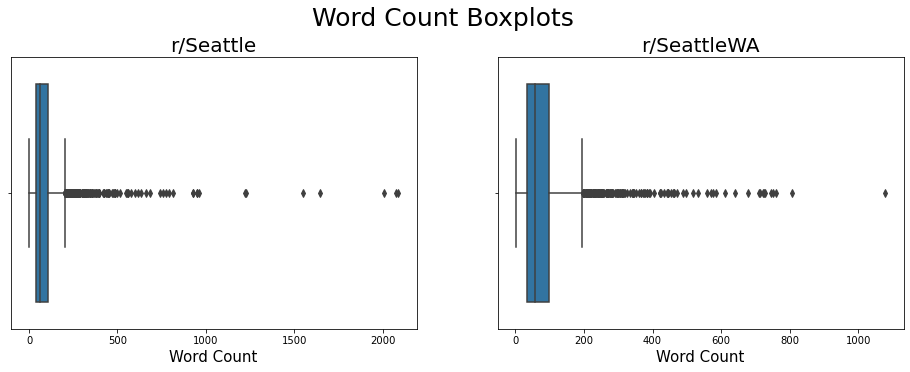

In [513]:
fig, axes = plt.subplots(1,2, figsize = (16,5))

fig.suptitle('Word Count Boxplots', size = 25, y = 1.02)
sns.boxplot(x = sea['word_count'], ax = axes[0])
axes[0].set_title('r/Seattle', size = 20)
axes[0].set_xlabel('Word Count', size = 15)

sns.boxplot(x = sea_wa['word_count'], ax = axes[1])
axes[1].set_title('r/SeattleWA', size = 20)
axes[1].set_xlabel('Word Count', size = 15);

In [514]:
sea['word_count'].describe()

count    2494.000000
mean       93.372093
std       127.130427
min         0.000000
25%        39.000000
50%        62.000000
75%       104.000000
max      2088.000000
Name: word_count, dtype: float64

There are several extraordinarily long posts in r/Seattle and at least one longer post in r/Seattle. Let us print the contents of these post to see if they make sense to remove from our datasets.

In [44]:
for entry in sea.loc[sea['word_count'] > 1500, 'text']:
    print(entry)
    print('-------\n')

Seattle City Council Newsletters Reddit: Hey everyone I just wanted to introduce myself again My name is George and I am a rising junior at Stanford interested in civic engagement and politics I started working on a project with other students that’s been totally awesome and cool Basically we’ve made a newsletter that summarizes the info from Seattle City Council meetings in an accessible and easy way I have put an example from this week below though the real thing has a bit more formatting that doesn't translate into Reddit This project is very new so we would really appreciate any feedback you may have I would love to see comments and show me what I need to do to make this newsletter the best it can be I totally recommend joining Who doesn’t want to know what goes on behind the scenes of their own beautiful city If you are interested in receiving these weekly in your email inbox you can click this link: Example Newsletter: Seattle City Council Meeting Summaries - Week of September 12

The only posts that immediately seem worthwhile dropping from r/Seattle are the City Council Newsletter post (the first entry above) and the post referring to Uvalde police (the second and third post above).

The City Council post seems to contain very specialized vocabulary and is lengthy by the nature of the post. These posts also seem regular though, so it would be out of place to drop just this especially lengthy post and not the other posts. Dropping all City Council posts by this person seems a bit excessive, so we will leave the City Council posts in.

There are two posts about Uvalde police. They appear to be identical except for some select words and some repeated characters that are used to distinguish the heading and body. I am sure there are more posts that are slightly off from being identical. We cannot remove them all, but since we stumbled upon this pair, we may as well remove one of them.

In [45]:
print(sea[sea['text'].str.contains('SPD should be barred from')].index)
sea.drop(index = 542, inplace = True)

Int64Index([536, 542], dtype='int64')


In [46]:
for entry in sea_wa.loc[sea_wa['word_count'] > 1000, 'text']:
    print(entry)
    print('-------\n')

Using Affordable Housing to get on The Property Ladder in Seattle The median home price in Seattle is now $934K A few years back I decided to settle down and buy a house but I couldn't come up with $200K for a down payment I used a fairly convoluted method to deal with that Someone on the forum asked me to elaborate how and why I did that so I thought I'd make a post When we started dating we were looking at places that were really farther from Seattle than is ideal Even places in Lynnwood were stretching our budget We were in a conundrum where it felt like our only option was having some nightmarish commute from Everett or renting indefinitely When the median home price in Seattle was $449K it was $182K in Las Vegas So we bought a place out there and rented it out Homes were so cheap one of the problems we had was getting financing Not because we couldn't qualify But because the loans were so small the banks didn't want to do them I learned that banks basically won't do loans for a ho

Nothing about the lengthiest post in r/SeattleWA suggests it needs to be removed. Let us leave it in.

Next let us look for posts that are too short to reasonably use.

In [51]:
sea.loc[sea['word_count'] < 10, 'text']

400                      The West Seattle Bridge is OPEN 
423     What’s with the Fighter jets over south seattl...
435               How has Seattle changed over the years 
757     Anyone recommend a good dental insurance compa...
768                               Earthquake  around 1:08
805                         Hi All Anyone from Kiingston 
1292                               Weaponizing your pets 
1346    Employment discrimination lawyer Any recommend...
1422                                Yo Seattle area 🔌 hmu
1425            Where’s the best quesadilla in town Title
1748                    hey guys I just wanted to say hey
1755         How’s the comedy scene here Need some laughs
1766    Seattle passes protections for abortion and ge...
1775    Best junkyards to pull parts from recommendati...
1782                              It’s thunder Move along
1838                              It's raining That's all
2277                      Somen soba in the city Any recs
2337          

The only post that obviously should be removed is the empty one at index 1191.

In [47]:
sea.drop(index = 1191, inplace = True)

For r/SeattleWA we can already see a pretty big difference below in the number of posts with fewer than 10 words and their content compared to r/Seattle. No posts here seem to require being dropped. Even the shorter posts convey a fair bit of sentiment.

There are:
- four posts about shootings (5, 6, 104, 2349)
- two posts are about urine (38, 1494) 
- one Pepe Silvia post - a meme about conspiracy theories (323)
- one post about being woke (1594)
- several sarcastic or contextually negative posts (235, 322, 430)

In [521]:
sea_wa.loc[sea_wa['word_count'] < 10, 'text']

5       Shooting near pioneer square Around 3:30 pm to...
6                             Shooting in Pioneer square 
38             Will piss mania come to seattle Piss mania
104                                   Another 1 Shooting 
110     Who's the most beautiful person you've seen in...
142            Inslee ending Covid-19 state of emergency 
149     What is considered greater Seattle What’s cons...
194                            Moderators what did I now 
235      Yup great minds coming through with the next ...
322                                          it's ironic 
323                                          Pepe Silvia 
373          Saxophone Anyone down to teach me saxophone 
389     any ideas what happened here Processing img 83...
403     didn't realize they put coloring books on the ...
430                                          Bye Felicia 
607     Any breakfast recommendations on the eastside ...
612                    Is this Seattle's signature scent 
749     Best s

Even when we examine an expanded the list of short posts from r/Seattle, the sentiment still differs from r/SeattleWA.

In [52]:
sea.loc[sea['word_count'] < 15, 'text']

96      Anyone else currently drunk running from their...
140     Recommend a nice sit-down lunch spot in the U ...
176     Traffic-geddon 9 23 What the hell happened out...
323     Best al pastor tacos in the area And do they u...
400                      The West Seattle Bridge is OPEN 
423     What’s with the Fighter jets over south seattl...
435               How has Seattle changed over the years 
436     Which do you like better Seattle or Vancouver ...
507     Can I sell u some cigarettes I ask them 2 for ...
538     Anyone have some insight on fun things to do d...
623     Boxing Where’s the best bar Pub to watch Boxin...
660     'Making good progress on negotiations' Seattle...
757     Anyone recommend a good dental insurance compa...
768                               Earthquake  around 1:08
775     car exploded next to me on i5 Processing video...
805                         Hi All Anyone from Kiingston 
929     Best Breakfast Burrito in Seattle What’s your ...
978     Does a

Even if we are lax about identifying negative posts, the posts in r/Seattle just seem less surly than r/SeattleWA. Below are posts that might be viewed as negative:
- explosions or booms (775, 1845, 2235)
- weaponizing your pets (1292)
- employment discrimination lawyer (1346)
- what in the world is going on (2032)
- shooting (2089)
- stay away from this person (2337)

#### Basic Visuals

We saw earlier from boxplots that r/seattle has more posts with very high word counts. Let us compare the distribution of posts with word counts below 1000.

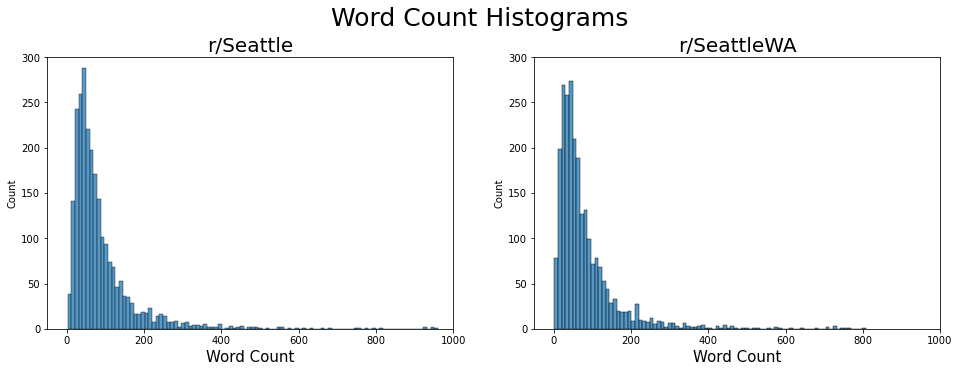

In [56]:
fig, axes = plt.subplots(1,2, figsize = (16,5))

sea_sub_1000 = sea[sea['word_count'] < 1000]
sea_wa_sub_1000 = sea_wa[sea_wa['word_count'] < 1000]

fig.suptitle('Word Count Histograms', size = 25, y = 1.02)
sns.histplot(x = sea_sub_1000['word_count'], ax = axes[0])
axes[0].set_title('r/Seattle', size = 20)
axes[0].set_xlabel('Word Count', size = 15)
axes[0].set_xlim(-50, 1000)
axes[0].set_ylim(-0, 300)

sns.histplot(x = sea_wa_sub_1000['word_count'], ax = axes[1])
axes[1].set_title('r/SeattleWA', size = 20)
axes[1].set_xlabel('Word Count', size = 15)
axes[1].set_xlim(-50, 1000)
axes[1].set_ylim(-0, 300);

The histogram shapes are nearly identical between the two subreddits. There may be slightly less volume on the left side of the r/SeattleWA histogram, but it is hard to say.

Next we look at the distributions of sentiment scores.

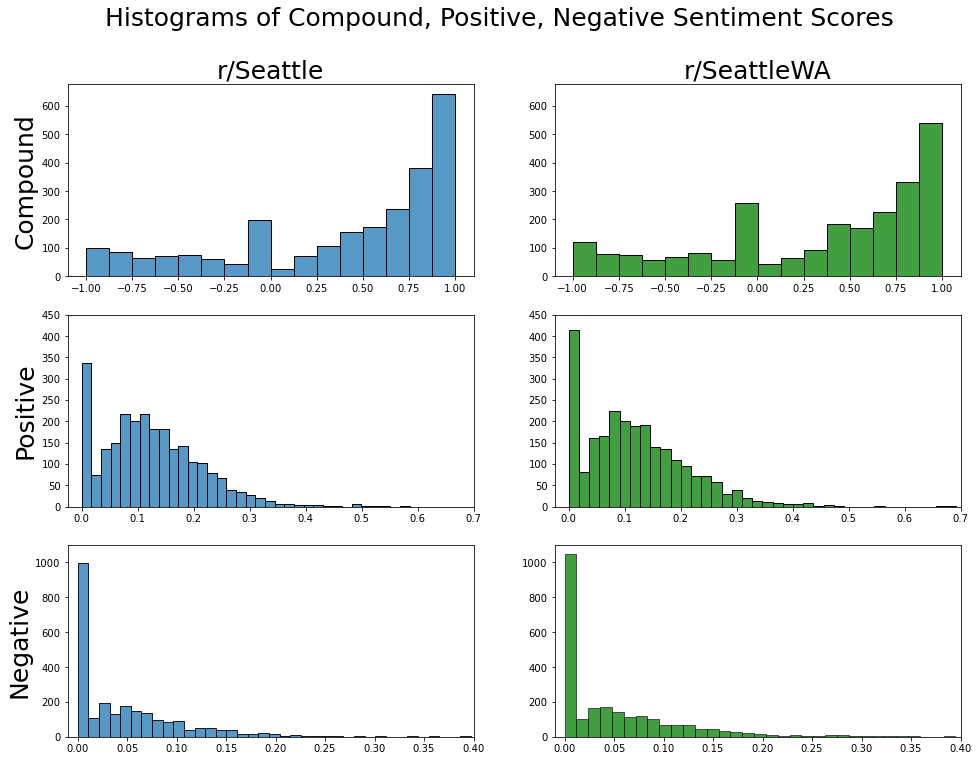

In [524]:
#from matplotlib.lines import Line2D

fig, axes = plt.subplots(3,2, figsize = (16,12))

fig.suptitle('Histograms of Compound, Positive, Negative Sentiment Scores', size = 25, y = 0.97)

#---------------------------
# r/Seattle sentiment scores
#---------------------------
sns.histplot(x = sea['sent_compound'], ax = axes[0,0])
axes[0,0].set_title('r/Seattle', size = 25)
axes[0,0].set_xlabel('', size = 15)
axes[0,0].set_ylabel('Compound', size = 25)
axes[0,0].set_ylim(0, 675)

sns.histplot(x = sea['sent_pos'], ax = axes[1,0])
#axes[1,0].set_title('Positive', size = 20)
axes[1,0].set_xlabel('', size = 15)
axes[1,0].set_ylabel('Positive', size = 25)
axes[1,0].set_xlim(-0.025, 0.7)
axes[1,0].set_ylim(0, 450)

sns.histplot(x = sea['sent_neg'], ax = axes[2,0])
#axes[2,0].set_title('Negative', size = 20)
axes[2,0].set_xlabel('', size = 15)
axes[2,0].set_ylabel('Negative', size = 25)
axes[2,0].set_xlim(-0.01, 0.4)
axes[2,0].set_ylim(0, 1100)


#-------------------------------
# # r/SeattleWA sentiment scores
#-------------------------------
sns.histplot(x = sea_wa['sent_compound'], ax = axes[0,1], color = 'green')
axes[0,1].set_title('r/SeattleWA', size = 25)
axes[0,1].set_xlabel('', size = 15)
axes[0,1].set_ylabel('', size = 15)
axes[0,1].set_ylim(0, 675)

sns.histplot(x = sea_wa['sent_pos'], ax = axes[1,1], color = 'green')
#axes[1,1].set_title('r/Seattle', size = 20)
axes[1,1].set_xlabel('', size = 15)
axes[1,1].set_ylabel('', size = 15)
axes[1,1].set_xlim(-0.025, 0.7)
axes[1,1].set_ylim(0, 450)

sns.histplot(x = sea_wa['sent_neg'], ax = axes[2,1], color = 'green')
#axes[1,2].set_title('r/Seattle', size = 20)
axes[2,1].set_xlabel('', size = 15)
axes[2,1].set_ylabel('', size = 15)
axes[2,1].set_xlim(-0.01, 0.4)
axes[2,1].set_ylim(0, 1100);

# custom legend
# legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='r/Seattle'), 
#                    Line2D([0], [0], color='tab:green', lw=4, label='r/SeattleWA'),]

# legend = axes[2,1].legend(handles = legend_elements, fontsize = 20);

The above plots show that the sentiment scores between r/Seattle and r/SeattleWA look very similar. The most notable differences are:
- the highest compound scores appear more frequently in r/Seattle
- the lowest positive scores appear more frequently in r/SeattleWA
- the higher negative scores appear slightly more frequently in r/SeattleWA

The first bullet on compound scores stands out the most and agrees with the first impressions of each subreddit. The second bullet also aligns with our impressions, but the rest of the positive sentiment histograms (outside of the leftmost bar) do not illustrate any differences between the two subreddits. The last bullet is hardly notable at all.

In [529]:
sea.to_csv('datasets/Cleaned_Seattle.csv', index = False)
sea_wa.to_csv('datasets/Cleaned_SeattleWA.csv', index = False)

---

## End of document

In [301]:
for entry in sea.loc[sea['text'].str.contains('board'), 'text'][:4]:
    print(entry)
    print('---')

a light rail interact wwyd r seattl thi first board lr ride airport when i walk car sat youngish mental ill woman baggi jean coat larg collect key chain like item midst rambl insult the aura gave someon enjoy parti one point life form self medic sinc consum mental ill i interact start brows phone i ride rail i begin realiz one side convers realli interact she begin say disord derogatori thing question at one point keep talk i said i want piss mom' mouth tri tell passeng i bomb ask i militari ask i want russian air strike i suck dick done coke serious ask question sometim actual question sometim word salad 45 minut without interact respond from time time would shout loudli tri get flinch at one point brought laser tri shine closer got airport escal attempt get attent she follow airport start scream hit object walk way i final trick duck park garag scream knock plastic sign howev clever manuev could escap persist wander ticket found follow tsa line stop board pass have dealt crazi peopl 

In [60]:
# elements in top 2000 words of one subreddit but not the other
sea_only_words_list = list(sea_words_set - set(words_in_common))
sea_wa_only_words_list = list(sea_wa_words_set - set(words_in_common))

In [61]:
len(sea_only_words_list)

354

In [62]:
sea_words_top_2k[sea_only_words_list].sort_values(ascending = False).head(25)

councilmemb    116
weekli          47
plane           34
optim           34
donat           33
track           33
adopt           33
roll            33
faq             31
strike          30
ordin           30
amend           30
zoo             30
2023            27
stick           27
band            26
quickli         25
recycl          24
director        24
machin          23
simpl           23
inflat          23
lyft            23
built           23
wide            23
dtype: int64

In [63]:
sea_wa_words_top_2k[sea_wa_only_words_list].sort_values(ascending = False).head(25)

march       39
patient     35
migrat      31
april       29
blog        28
mandat      28
client      26
particip    25
4th         23
closur      22
assault     21
vegan       21
john        21
conserv     20
judg        20
crimin      20
tab         19
gain        19
tv          19
discount    19
convert     19
radio       19
shower      19
furnitur    19
fellow      19
dtype: int64

We see councilmemb appear quite a bit in r/Seattle and not appear in r/SeattleWA. This was because there was a Stanford student who would regularly post details about City Council meetings in r/Seattle.

Besides that, notable words that appeared in r/Seattle but not r/SeattleWA:
- optim
- donat
- adopt
- strike
- ordin
- amend
- recycl
- inflat
- lyft

And notable words that appeared in r/SeattleWA but not r/Seattle:
- patient
- migrat
- mandat
- 4th
- closur
- assault
- conserv
- judg
- crimin
- convert



In [246]:
sea_only = sea_words_top_2k[sea_only_words_list].sort_values(ascending = False).head(25)
sea_wa_only = sea_wa_words_top_2k[sea_wa_only_words_list].sort_values(ascending = False).head(25)
sea_only_df = pd.DataFrame(sea_only, columns = ['count']).reset_index()
sea_wa_only_df = pd.DataFrame(sea_wa_only, columns = ['count']).reset_index()

C:\Users\John\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\John\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



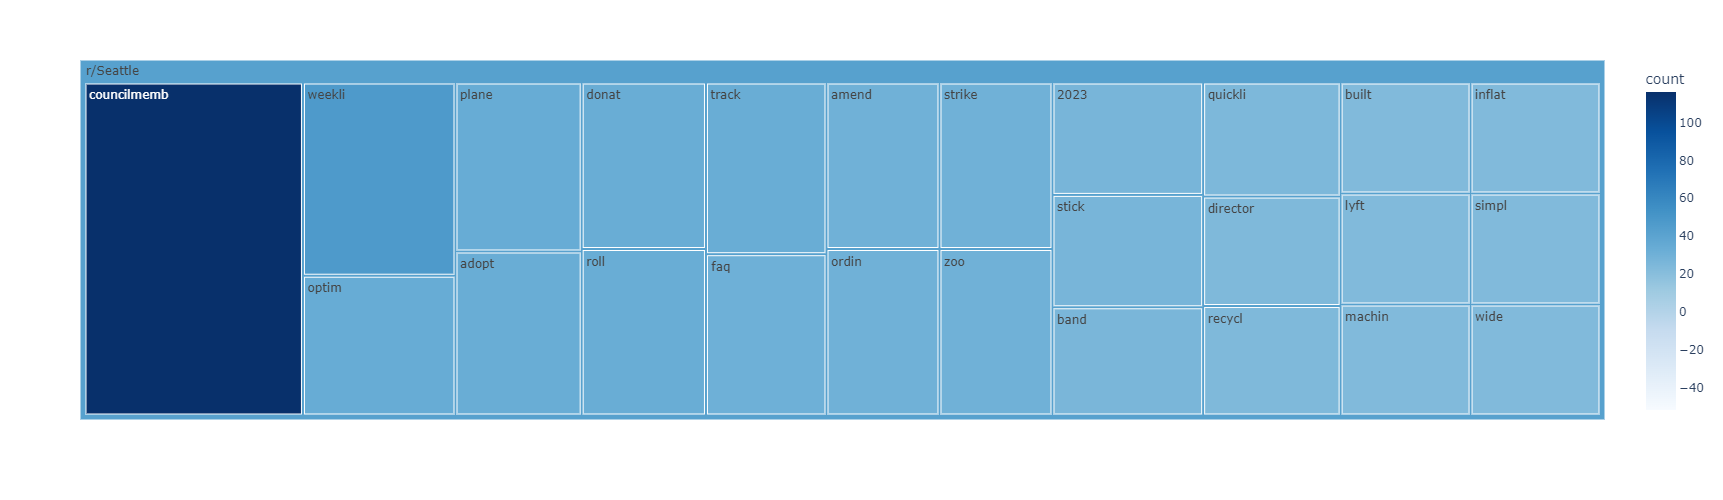

In [250]:
fig = px.treemap(sea_only_df, path=[px.Constant('r/Seattle'), 'index'], values='count', color = 'count', width = 1200, height = 500, color_continuous_scale= 'Blues', color_continuous_midpoint= np.mean(sea_only_df['count']))
fig.show()

C:\Users\John\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\John\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



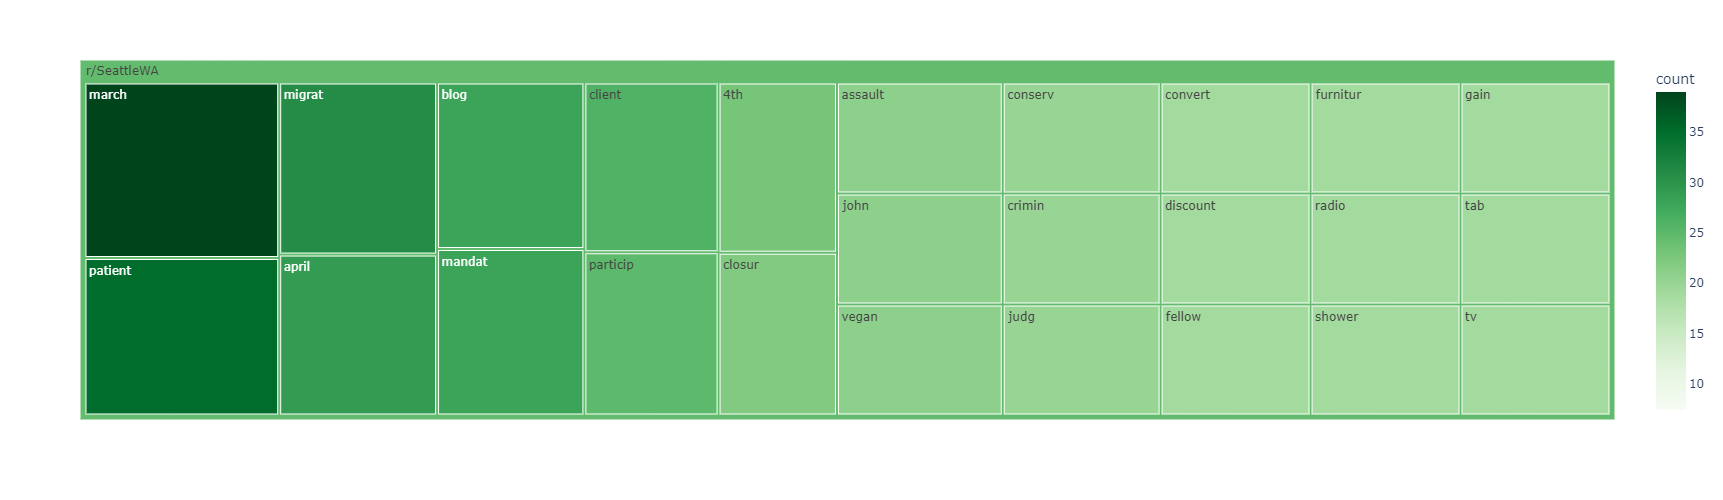

In [260]:
fig = px.treemap(sea_wa_only_df, path=[px.Constant('r/SeattleWA'), 'index'], values='count', color = 'count', width = 1200, height = 500, color_continuous_scale= 'Greens', color_continuous_midpoint= np.mean(sea_wa_only_df['count']))
fig.show()

In [69]:
ranking_difference[ranking_difference == 0]

success    0.0
well       0.0
anywher    0.0
anyth      0.0
folk       0.0
anyon      0.0
check      0.0
sick       0.0
part       0.0
like       0.0
seattl     0.0
doesn      0.0
find       0.0
fli        0.0
thing      0.0
confirm    0.0
liter      0.0
author     0.0
came       0.0
mention    0.0
could      0.0
bu         0.0
dtype: float64

Here are words that had the same ranking in both subreddits. Nothing too interesting here.

In [261]:
cvec = CountVectorizer(max_features = 1000, ngram_range=(2,2))

# collect 1,000 most frequent bi-grams appearing in r/Seattle
sea_bigram_freq = cvec.fit_transform(sea['text'])
sea_bigram_freq = pd.DataFrame(sea_bigram_freq.todense(), columns = cvec.get_feature_names_out())
sea_bigrams = sea_bigram_freq.sum().sort_values(ascending = False)

# collect 1,000 most frequent bi-grams appearing in r/SeattleWA
sea_wa_bigram_freq = cvec.fit_transform(sea_wa['text'])
sea_wa_bigram_freq = pd.DataFrame(sea_wa_bigram_freq.todense(), columns = cvec.get_feature_names_out())
sea_wa_bigrams = sea_wa_bigram_freq.sum().sort_values(ascending = False)

In [265]:
sea_bigrams.head(25)

anyon know         200
doe anyon          160
seattl area        129
move seattl        126
thank advanc        97
first time          82
would like          82
anyon els           76
capitol hill        75
would love          75
light rail          70
visit seattl        67
seem like           65
feel like           65
ani recommend       59
let know            53
west seattl         53
look like           51
ha anyon            50
year old            50
year ago            47
king counti         47
pike place          47
ani suggest         46
anyon recommend     44
dtype: int64

In [266]:
sea_wa_bigrams.head(25)

anyon know          159
move seattl         141
doe anyon           129
seattl area         126
thank advanc         81
would like           76
king counti          68
capitol hill         62
visit seattl         62
would love           60
anyon els            58
let know             57
look like            57
feel like            54
seem like            54
first time           51
year old             50
downtown seattl      46
live seattl          46
last year            43
west seattl          43
washington state     41
anyon recommend      40
wonder anyon         38
ani recommend        38
dtype: int64

In [271]:
sea_bigrams_set = set(sea_bigrams.index)
sea_wa_bigrams_set = set(sea_wa_bigrams.index)

common_bi = sea_bigrams_set.intersection(sea_wa_bigrams_set)
sea_only_bi = sea_bigrams_set - common_bi
sea_wa_only_bi = sea_wa_bigrams_set - common_bi

In [281]:
sea_bigrams_top15 = sea_bigrams[list(common_bi)].sort_values(ascending = False).head(15)
sea_wa_bigrams_top15 = sea_wa_bigrams[list(common_bi)].sort_values(ascending = False).head(15)

In [282]:
sea_bigrams_top15

anyon know       200
doe anyon        160
seattl area      129
move seattl      126
thank advanc      97
first time        82
would like        82
anyon els         76
capitol hill      75
would love        75
light rail        70
visit seattl      67
seem like         65
feel like         65
ani recommend     59
dtype: int64

In [283]:
sea_wa_bigrams_top15

anyon know      159
move seattl     141
doe anyon       129
seattl area     126
thank advanc     81
would like       76
king counti      68
capitol hill     62
visit seattl     62
would love       60
anyon els        58
look like        57
let know         57
seem like        54
feel like        54
dtype: int64

In [285]:
sea_bigrams[list(sea_only_bi)].sort_values(ascending = False).head(15)

sponsor councilmemb     42
if question             23
blue line               22
council meet            20
move visit              20
citi light              20
know there              20
councilmemb ye          20
school board            18
councilmemb district    18
seattl song             18
would go                18
board game              17
let us                  17
uber lyft               17
dtype: int64

In [303]:
# Three posts on r/Seattle contain all instances of blue line
for entry in sea.loc[sea['text'].str.contains('blue line'), 'text'][:5]:
    print(entry)
    print('---')

spd bar display thin blue line symbol spog abolish the myth lynchpin offic die uvald with dear children myth lynchpin offic die uvald by doctrin the thin blue line polic requir broad discret use-of-forc decis thi offic hold line order chao improperli restrain polic may fail – case someth terribl could happen lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll a grand juri assembl denver polic shot six innoc bystand fail attempt kill man who’d surrend lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll the thin blue line come repres distinct ideolog wide adopt polic throughout us thi clearli extremist ideolog though simpl proposit guid organ train profession conduct law enforc organ nationwid thi problem requir immedi attent forc action becaus polic o

In [284]:
sea_wa_bigrams[list(sea_wa_only_bi)].sort_values(ascending = False).head(15)

wear mask          24
two ticket         23
sell ticket        19
south lake         18
think move         17
red light          16
dental hygien      16
long stori         16
speed limit        16
mask mandat        16
seattl bellevu     16
catalyt convert    15
hygien student     15
state depart       14
park ticket        14
dtype: int64

In [304]:
# Three posts on r/Seattle contain all instances of blue line
for entry in sea_wa.loc[sea_wa['text'].str.contains('wear mask'), 'text'][:5]:
    print(entry)
    print('---')

i know linger mask requir bother i close saint bread week ago want treat drove look park saw still requir mask even though counter basic outsid their outdoor patio patron wear mask so i kept drive went anoth bakeri there' "the science" suggest wear mask scenario measur impact \duck cover\ haha
---
employ requir me come back covid posit i work front desk hotel bellevu i test posit covid manag ask come regardless wear mask is legal consid stage covid i’m familiar regul covid today help would appreci folk
---
whi mostli asian still wear mask is alreadi use communist authoritarian countri
---
to wear mask wrong i find baffl mani peopl i see wear mask wrong day almost nowher requir mask day want wear one it' two year feel wear one sure know right so what' not hear shit anyon stir pot i find behavior bizarr
---
look like custom servic seattle' king counti prioriti anymor i multipl experi i thought custom servic suck 1 thi chipotl redmond wa: never order prepar time around 30% time forget pre

In [310]:
#sea_wa_bigrams_top15 = sea_wa_bigrams[list(common_bi)].sort_values(ascending = False).head(15)